In [ ]:
import numpy as np
import pandas as pd
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2

img = cv2.imread("/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train/cancer/Bengin case (101).jpg")

img.shape

(400, 400, 3)

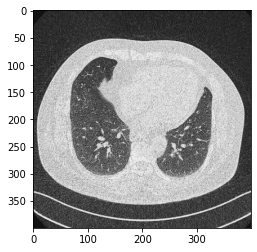

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train_dir="/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train/"
test_dir="/content/drive/MyDrive/LUNGCANCER/Lung_data_new/test/"

In [ ]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224,224),
                                                                 label_mode = "categorical",
                                                                 batch_size = 32
                                                                 )
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size =(224,224),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )

Found 1861 files belonging to 2 classes.
Found 750 files belonging to 2 classes.


In [ ]:
for image, label in train_data:
  print(image.shape)
  print(label.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [ ]:
import cv2
import os
# no_tümör için görüntü ön işleme
no_tumor_dir=""
images=[x for x in os.listdir(no_tumor_dir)]
for i in images:
    img= cv2.imread(r'/content/drive/MyDrive/data_set/train/no' +"/"+i)
    scale_percent = 60 # orjinal boyutun yüzdesi
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(no_tumor_dir+"/"+"aug"+i,resized)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
trainDataGen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    zoom_range=0.2,


)
testDataGen=ImageDataGenerator(rescale=1./255)

trainGen=trainDataGen.flow_from_directory(train_dir,
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=128,
                                          subset='training'
                                         )
testGen=testDataGen.flow_from_directory(test_dir, target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=1)

valGen=trainDataGen.flow_from_directory(train_dir, target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=128,subset='validation')


Found 1676 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 185 images belonging to 2 classes.


In [ ]:
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from keras.applications.vgg16 import VGG16

base_model=VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

x=Flatten()(base_model.output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(1024,activation='relu')(x)
out=Dense(2,activation='softmax')(x)

model=Model(inputs=base_model.inputs,outputs=out)
for layer in model.layers[:22]:
  layer.trainable=False

for layer in model.layers:
  print(layer.name," ",layer.trainable)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
input_1   False
block1_conv1   False
block1_conv2   False
block1_pool   False
block2_conv1   False
block2_conv2   False
block2_pool   False
block3_conv1   False
block3_conv2   False
block3_conv3   False
block3_pool   False
block4_conv1   False
block4_conv2   False
block4_conv3   False
block4_pool   False
block5_conv1   False
block5_conv2   False
block5_conv3   False
block5_pool   False
flatten   False
dense   False
dropout   False
dense_1   True
dense_2   True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      3692

In [ ]:
label_names = train_data.class_names

label_names, len(label_names)

(['cancer', 'no_cancer'], 2)

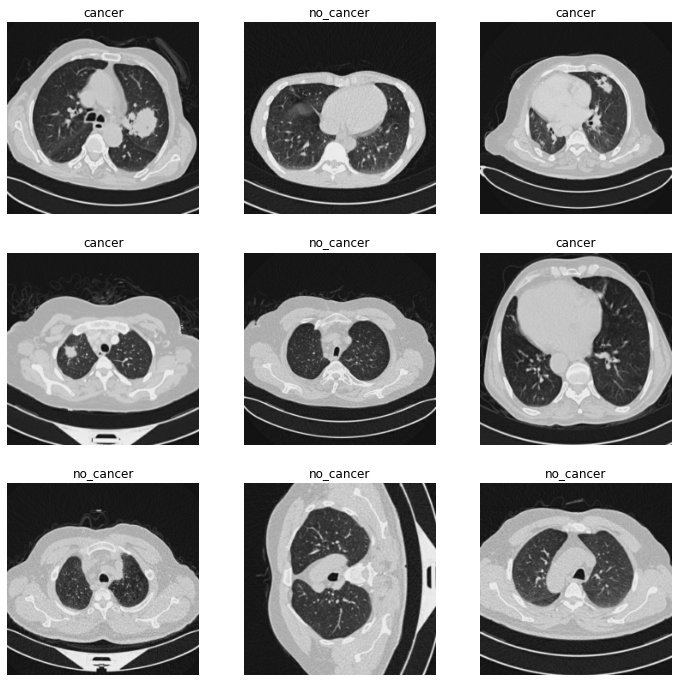

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(12,12))

for image, label in train_data.take(1):

  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(label_names[tf.argmax(label[i])])
    plt.axis("off")

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks=[EarlyStopping(monitor='val_loss',patience=10), ModelCheckpoint(filepath="best_model.h5",monitor='val_loss',save_best_only=True)]


model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

In [ ]:
steps_per_epochs=trainGen.samples//128
print(steps_per_epochs)
validation_steps_=valGen.samples//128
print(validation_steps_)

13
1


In [ ]:
history=model.fit(trainGen,steps_per_epoch=steps_per_epochs,validation_data=valGen,epochs=50,validation_steps=validation_steps_,callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 270s 19s/step - loss: 1.3507 - accuracy: 0.5381 - val_loss: 0.8680 - val_accuracy: 0.5312
Epoch 2/50
13/13 [==============================] - 35s 3s/step - loss: 0.6993 - accuracy: 0.5904 - val_loss: 0.6204 - val_accuracy: 0.6797
Epoch 3/50
13/13 [==============================] - 34s 3s/step - loss: 0.5422 - accuracy: 0.7293 - val_loss: 0.6621 - val_accuracy: 0.6094
Epoch 4/50
13/13 [==============================] - 34s 3s/step - loss: 0.4821 - accuracy: 0.7804 - val_loss: 0.6817 - val_accuracy: 0.5547
Epoch 5/50
13/13 [==============================] - 37s 3s/step - loss: 0.4449 - accuracy: 0.7972 - val_loss: 0.7621 - val_accuracy: 0.5938
Epoch 6/50
13/13 [==============================] - 35s 3s/step - loss: 0.4084 - accuracy: 0.8217 - val_loss: 0.7669 - val_accuracy: 0.5156
Epoch 7/50
13/13 [==============================] - 36s 3s/step - loss: 0.3999 - accuracy: 0.8191 - val_loss: 0.8272 - val_accuracy: 0.5703
Epoch 8/50
13/13 [

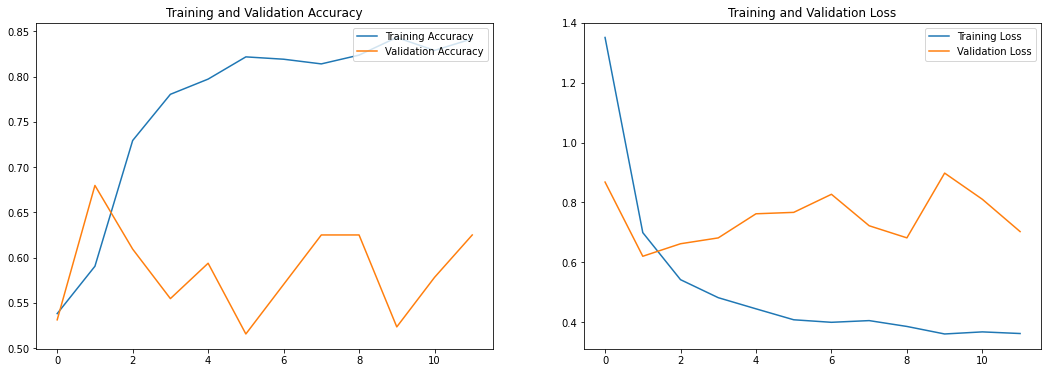

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
train_dir = "/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train/"
test_dir = "/content/drive/MyDrive/LUNGCANCER/Lung_data_new/test"

In [ ]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224,224),
                                                                 label_mode = "categorical",
                                                                 batch_size = 32
                                                                 )
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size =(224,224),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )


Found 1861 files belonging to 2 classes.
Found 750 files belonging to 2 classes.


In [ ]:
# tunning the model
base_model.trainable = True
import tensorflow as tf
for layer in base_model.layers[:-1]:
  base_model.trainable = False

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [ ]:
# fitting data to the tuned model

h_t=model.fit(train_data,
          epochs = 10,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data)
          )

Epoch 1/10
59/59 [==============================] - 157s 3s/step - loss: 4.4955 - accuracy: 0.7722 - val_loss: 0.0724 - val_accuracy: 0.9760
Epoch 2/10
59/59 [==============================] - 27s 437ms/step - loss: 0.3729 - accuracy: 0.8743 - val_loss: 0.1267 - val_accuracy: 0.9467
Epoch 3/10
59/59 [==============================] - 27s 438ms/step - loss: 0.1978 - accuracy: 0.9167 - val_loss: 0.1132 - val_accuracy: 0.9653
Epoch 4/10
59/59 [==============================] - 27s 438ms/step - loss: 0.1814 - accuracy: 0.9264 - val_loss: 0.0685 - val_accuracy: 0.9747
Epoch 5/10
59/59 [==============================] - 27s 437ms/step - loss: 0.1332 - accuracy: 0.9506 - val_loss: 0.0504 - val_accuracy: 0.9813
Epoch 6/10
59/59 [==============================] - 27s 438ms/step - loss: 0.1112 - accuracy: 0.9608 - val_loss: 0.0211 - val_accuracy: 0.9920
Epoch 7/10
59/59 [==============================] - 26s 438ms/step - loss: 0.0700 - accuracy: 0.9747 - val_loss: 0.0171 - val_accuracy: 0.9907
E

In [ ]:
# evaluatinn the model
model_evaluation = model.evaluate(test_data)

24/24 [==============================] - 8s 301ms/step - loss: 0.1197 - accuracy: 0.9720


In [ ]:
print(f"Model Accuracy:{model_evaluation[1] *100: 0.2f} %")

Model Accuracy: 97.20 %


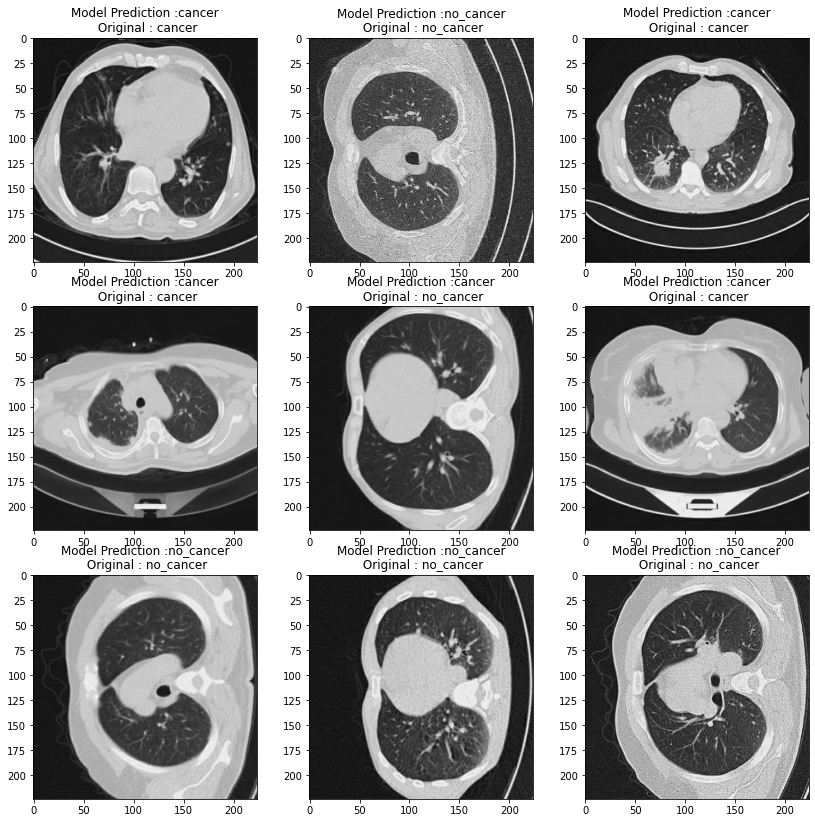

In [ ]:
# predicting and visualizing the test data
import tensorflow as tf
import matplotlib.pyplot as plt

plt.figure(figsize=(14,14))

for image, label in test_data.take(1):
  model_prediction = model.predict(image)

  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction :{label_names[tf.argmax(model_prediction[i])]}\n Original : {label_names[tf.argmax(label[i])]}")

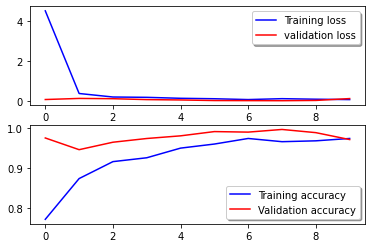

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(h_t.history['loss'], color='b', label="Training loss")
ax[0].plot(h_t.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(h_t.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(h_t.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)